In [ ]:
install = False #if the first time, needs to download packages from nltk
if install:
    import nltk
    nltk.download('wordnet')
    nltk.download('punkt')
    nltk.download('floresta')
    

In [ ]:
import enum
import pandas as pd 
import numpy as np

from pathlib import Path

from IPython.display import display

import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#from nltk.corpus import conll2000
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.chunk import ne_chunk
from nltk import pos_tag

from nltk.util import ngrams

from NLPyPort.LemPyPort import LemFunctions #https://github.com/NLP-CISUC/NLPyPort
from NLPyPort.FullPipeline import *

from collections import defaultdict

class Languages(enum.Enum):
     Portuguese = 2
     English = 1

from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None     



In [ ]:
%load_ext autoreload

%autoreload 2

In [ ]:
#PARAMETER path to book and its language

bookfilename=r'D:\angelo-docs\python\livros\ossertoes-euclidesdacunha\Os_Sertoes.txt'

booktitle='Os Sertões'

language = Languages.Portuguese

#language = Languages.English


In [ ]:
#check if text file was processed before

p = Path(bookfilename)

display("Checking file {} in path {}".format(p.name,p.parent))

assert p.exists(), '{} does not exist!'.format(bookfilename)

cachetokenfile = p.with_name('{}_tokenscache.csv'.format(p.name.replace('.','')))

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

if cachetokenfile.exists():
    print('found cache tokens for {} ...'.format(bookfilename))
    wordtk = pd.read_csv(cachetokenfile, index_col=False)
    raise StopExecution

# text file will be processed now    
    
if(language == Languages.Portuguese):
    
    print('reading file {} ...'.format(bookfilename))

    config_list = load_congif_to_list()
    
    options = {
                "tokenizer" : True,
                "pos_tagger" : True,
                "lemmatizer" : True,
                "entity_recognition" : True,
                "np_chunking" : False,
                "pre_load" : True,
                "string_or_array" : False
    }

    text = new_full_pipe(bookfilename,options=options,config_list=config_list)

    wordtk = pd.DataFrame(columns=['token','lemma','entity','pos_tagger'])
    
    print('finished processing file!')

    wordtk['token'] = text.tokens
    wordtk['lemma'] = text.lemas
    wordtk['entity'] = text.entities
    wordtk['pos_tagger'] = text.pos_tags

    wordtk.to_csv(cachetokenfile, index=False)
#end if(language == Languages.Portuguese) 

    
if(language == Languages.English):
    lemmatizer = WordNetLemmatizer() #Lemmatize using WordNet's built-in morphy function. ENGLISH
    sent_detector  = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
    
    print('reading file {} ...'.format(bookfilename))

    tkdic = []
    with open(filename, "r", encoding='utf-8') as f:
        try:
            for line in f:            
                if not line.strip(): #empty line
                    continue #jump to next line

                sentences = sent_detector.tokenize(line.strip())
                for s in sentences:
                    tokens = word_tokenize(s, language='english', preserve_line=True)            
                    ne_iob = tree2conlltags(ne_chunk(pos_tag(tokens))) #now a list of tuples (word, tag, IOB-tag)
                    for w in ne_iob:
                        tkdic.append({'token':w[0],
                                      'lemma':lemmatizer.lemmatize(w[0], pos=get_wordnet_pos(w[1])),
                                      'entity':w[2],
                                      'pos_tagger':w[1]
                                     })
                    print('finished processing file!')
        finally:
            f.close()
        wordtk = pd.DataFrame.from_dict( tkdic )
        wordtk.to_csv(cachetokenfile, index=False)
#end if(language == Languages.English) 



In [ ]:
#identify sentence limits by dot(.) as end of sentence

if(language == Languages.Portuguese):
    wordtk['dot'] = 0
    wordtk.loc[wordtk['token']=='.','dot'] = 1
    wordtk.loc[wordtk['token']=='...','dot'] = 1
    wordtk['sentencenumber'] = wordtk['dot'].cumsum()+1
    #adjust sentence 
    wordtk.loc[wordtk['sentencenumber']==(wordtk['sentencenumber'].shift(1)+1),'sentencenumber'] = wordtk['sentencenumber']-1
    
if(language == Languages.English):
    pass #????
    
    

In [118]:
#display initial e final tokens from the processed text file
display(wordtk.head(10))
display(wordtk.tail(10))    

display(wordtk[(wordtk['dot']==1) | (wordtk['dot'].shift(1)==1) | (wordtk['dot'].shift(-1)==1)].head(10))

token     lemma    entity pos_tagger  dot  sentencenumber
0         1         1         O        num    0               1
1       EOS       EOS       EOS        EOS    0               1
2       EOS       EOS       EOS        EOS    0               1
3        Os         o         O        art    0               1
4   Sertões    sertõe  B-PESSOA          N    0               1
5       EOS       EOS       EOS        EOS    0               1
6  Euclides  euclides         O       prop    0               1
7        de        de         O        prp    0               1
8         a         o         O        art    0               1
9     Cunha     cunha         O          N    0               1

token     lemma    entity pos_tagger  dot  sentencenumber
216672    4-1903    4-1903         O          N    0            7865
216673         .         .         O       punc    1            7865
216674  Euclides  euclides         O       prop    0            7866
216675        de        de         O        prp    0            7866
216676         a         o         O        art    0            7866
216677     Cunha     cunha  B-PESSOA          N    0            7866
216678         .         .         O       punc    1            7866
216679       EOS       EOS       EOS        EOS    0            7867
216680       EOS       EOS       EOS        EOS    0            7867
216681       EOS       EOS       EOS        EOS    0            7867

token    lemma   entity pos_tagger  dot  sentencenumber
62   apontar  apontar        O      v-inf    0               1
63         .        .        O       punc    1               1
64       EOS      EOS      EOS        EOS    0               2
91   sugeriu  sugeriu        O          N    0               2
92         .        .        O       punc    1               2
93       EOS      EOS      EOS        EOS    0               3
119   Brasil   brasil  B-LOCAL       prop    0               3
120        .        .        O       punc    1               3
121        E        e        O     conj-c    0               4
185    terra    terra        O          n    0               4

In [127]:
display(wordtk.groupby('pos_tagger').count()[['token']])

display(wordtk[wordtk['pos_tagger']=='prp'].head(10))

display(wordtk[wordtk['token']==')'].head(10))

display(wordtk[wordtk['token']=='nÃ³s'].head(10)) #nÃ³s eq nós


token
pos_tagger       
ADP          1209
EOS         14629
N           44027
adj          8267
adv          7400
art         27327
conj-c       5632
conj-s       1735
in              5
intj            1
n           25301
n-adj          46
num          1600
pron-det     5533
pron-indp    2786
pron-pers    4583
prop          866
prp         27996
punc        27556
v-fin        5802
v-ger         949
v-inf        1304
v-pcp        2128

token lemma  entity pos_tagger  dot  sentencenumber
7     de    de       O        prp    0               1
16    em    em       O        prp    0               1
20    de    de       O        prp    0               1
22    de    de       O        prp    0               1
38    de    de       O        prp    0               1
41    de    de  I-OBRA        prp    0               1
54    em    em       O        prp    0               1
56    de    de       O        prp    0               1
60   por   por       O        prp    0               1
65     a     a       O        prp    0               2

token lemma entity pos_tagger  dot  sentencenumber
2817      )     )      O          N    0              80
3465      )     )      O          N    0             102
11446     )     )      O          N    0             336
11450     )     )      O          N    0             336
11454     )     )      O          N    0             336
11458     )     )      O          N    0             336
11462     )     )      O          N    0             336
11475     )     )      O          N    0             336
11479     )     )      O          N    0             336
11482     )     )      O          N    0             336

token lemma entity pos_tagger  dot  sentencenumber
4922   nÃ³s   nã³      O          N    0             145
11241  nÃ³s   nã³      O          N    0             331
12526  nÃ³s   nã³      O          N    0             363
13177  nÃ³s   nã³      O          N    0             376
17264  nÃ³s   nã³      O          N    0             490
19045  nÃ³s   nã³      O          N    0             550
22693  nÃ³s   nã³      O          N    0             693
24041  nÃ³s   nã³      O          N    0             739
30355  nÃ³s   nã³      O          N    0             945
32414  nÃ³s   nã³      O          N    0            1023

In [223]:
display(wordtk[wordtk['pos_tagger']=='prop']['token'].unique()[:10])

array(['Euclides', 'Brasil', 'História', 'Europa', 'Rio', 'Grande',
       'Bahia', 'Iguaçu', 'Tietê', 'Paraná'], dtype=object)

In [260]:
#create sentences statistics

def listNE(df):
    #groupdf[ groupdf['entity']!='O' ]
    result = []
    tmp = []
    for index,row in df.iterrows():
        if row['entity'] not in ['O','EOS']:
            tmp.append(row['token'])
        else:
            if tmp: #not empty
                result.append(tmp)
                tmp = []
    if tmp: #not empty
        result.append(tmp)
    return result

#display(wordtk[ (wordtk['pos_tagger']!='EOS') & (wordtk['pos_tagger']!='punc') ].head(25))

#word count by sentence
#sentences = wordtk[ (wordtk['pos_tagger']!='EOS') & (wordtk['pos_tagger']!='punc') 
#                   & (wordtk['token']!=')') & (wordtk['token']!='(')].groupby('sentencenumber')[['token']].count()
#sentences = sentences.reset_index().rename(columns={"token": "tokencount"})
#display(sentences.head(5))

ignore_postag = ['prp','ADP','art','conj-c','conj-s','pron-det','pron-indp','pron-pers']
ignore_token = [')','(','—','...',':','``',"''"]
#prp preposição, ADP - adpositions (prepositions and postpositions), art artigo

groupsentence = wordtk[ (wordtk['pos_tagger']!='EOS') & (wordtk['pos_tagger']!='punc') 
                   & (~wordtk['token'].isin(ignore_token) )].groupby('sentencenumber')

sentencelist = []

for groupname, groupdf in groupsentence:
    cuttokens = groupdf[ ~groupdf['pos_tagger'].isin(ignore_postag) ]
    ne = listNE(groupdf)
    sentencelist.append({"sentencenumber":groupname, 
                         "tokenlist":groupdf['token'].tolist(), 
                         "tokencount":groupdf['token'].count(),
                         "tokencutlist":cuttokens['token'].tolist(), 
                         "tokencutcount":cuttokens['token'].count(),
                         "lemmalist":groupdf['lemma'].tolist(),
                         "lemmacount":groupdf['lemma'].count(),
                         "namedentities": ne #TODO tie NE to token
                        })
    
sentences = pd.DataFrame.from_dict( sentencelist )    
display(sentences.head(5))





sentencenumber                                          tokenlist  \
0               1  [1, Os, Sertões, Euclides, de, a, Cunha, Nota,...   
1               2  [a, ele, Demos-, por, isto, outra, feição, tom...   
2               3  [Intentamos, esboçar, palidamente, embora, ant...   
3               4  [E, fazêmo-lo, porque, a, sua, instabilidade, ...   
4               5  [O, jagunço, destemeroso, o, tabaréu, ingênuo,...   

   tokencount                                       tokencutlist  \
0          51  [1, Sertões, Euclides, Cunha, Nota, Preliminar...   
1          21  [Demos-, feição, tomando, apenas, variante, as...   
2          22  [Intentamos, esboçar, palidamente, ante, olhar...   
3          57  [fazêmo-lo, instabilidade, complexos, fatores,...   
4          20  [jagunço, destemeroso, tabaréu, ingênuo, caipi...   

   tokencutcount                                          lemmalist  \
0             27  [1, o, sertõe, euclides, de, o, cunha, nota, p...   
1             11  [a, ele, demo, por, isto, outro, feição, tomar...   
2             14  [intentamo, esboçar, palidamente, embora, ante...   
3             34  [e, fazêmo-lo, porque, o, seu, instabilidade, ...   
4             14  [o, jagunço, destemeroso, o, tabaréu, ingênuo,...   

   lemmacount                         namedentities  
0          51  [[Sertões], [Campanha, de, Canudos]]  
1          21                                    []  
2          22                            [[Brasil]]  
3          57                                    []  
4          20                                    []

In [250]:
display(wordtk[~wordtk['entity'].isin(['O','EOS'])].head(50))

display(sentences[sentences['sentencenumber']==1])



token         lemma    entity pos_tagger  dot  sentencenumber
4           Sertões        sertõe  B-PESSOA          N    0               1
40         Campanha      campanha    B-OBRA          n    0               1
41               de            de    I-OBRA        prp    0               1
42          Canudos        canudo    I-OBRA          N    0               1
119          Brasil        brasil   B-LOCAL       prop    0               3
264              em            em   B-TEMPO        prp    0               7
265            este          este   I-TEMPO   pron-det    0               7
266          século        século   I-TEMPO          n    0               7
269   Retardatários  retardatário   B-TEMPO          N    0               8
270            hoje          hoje   I-TEMPO        adv    0               8
272          amanhã        amanhã   B-TEMPO        adv    0               8
304          Hobbes         hobbe  B-PESSOA          N    0               9
331         Canudos        canudo   B-LOCAL          N    0              10
383       Atlântico     atlântico   B-LOCAL          N    0              11
392          Europa        europa   B-LOCAL       prop    0              11
598           Cunha         cunha  B-PESSOA          N    0              18
601             São           são   B-LOCAL      v-fin    0              19
602           Paulo         paulo   I-LOCAL          N    0              19
628           Monte         monte   B-LOCAL          N    0              22
629           Santo         santo   I-LOCAL          N    0              22
650           Monte         monte   B-LOCAL          N    0              26
651           Santo         santo   I-LOCAL          N    0              26
671              As             o   B-TEMPO        art    0              32
672           secas          seco   I-TEMPO        adj    0              32
689           Hegel         hegel  B-PESSOA          N    0              35
724        Planalto      planalto   B-LOCAL          n    0              39
725         Central       central   I-LOCAL          N    0              39
728          Brasil        brasil   B-LOCAL       prop    0              39
736             Sul           sul  B-PESSOA          n    0              39
769             Rio           rio   B-LOCAL       prop    0              40
770          Grande        grande   I-LOCAL       prop    0              40
771               a             a   I-LOCAL        prp    0              40
772           Minas          mina   I-LOCAL          N    0              40
880             Rio           rio   B-LOCAL       prop    0              42
881              de            de   I-LOCAL        prp    0              42
882         Janeiro       janeiro   I-LOCAL          n    0              42
885        Espírito        espíro   B-LOCAL          N    0              42
886           Santo         santo   I-LOCAL          N    0              42
1000          Bahia         bahia   B-LOCAL       prop    0              42
1080             S.            s.   B-COISA          N    0              44
1081      Francisco     francisco   I-COISA          N    0              44
1257          Rocha         rocha  B-PESSOA          N    0              48
1404              5             5    I-OBRA        num    0              51
1407          Tietê         tietê    I-OBRA       prop    0              51
1519    Mantiqueira   mantiqueiro   B-LOCAL          N    0              54
1525        Paraíba       paraíba   B-LOCAL       prop    0              54
1566         Estado        estado  B-PESSOA          n    0              55
1591            São           são   B-LOCAL      v-fin    0              56
1592          Paulo         paulo   I-LOCAL          N    0              56
1626         Grande        grande   B-LOCAL       prop    0              56

sentencenumber                                          tokenlist  \
0               1  [1, Os, Sertões, Euclides, de, a, Cunha, Nota,...   

   tokencount                                       tokencutlist  \
0          51  [1, Sertões, Euclides, Cunha, Nota, Preliminar...   

   tokencutcount                                          lemmalist  \
0             27  [1, o, sertõe, euclides, de, o, cunha, nota, p...   

   lemmacount                                      namedentities  
0          51  [[], [], [Sertões], [], [], [], [], [], [], []...

In [203]:
#evaluate token intermittency

#create sequential list of tokens

worddf = wordtk[ (wordtk['pos_tagger']!='EOS') & (wordtk['pos_tagger']!='punc') 
               & (wordtk['token']!=')') & (wordtk['token']!='(')][['token']].reset_index()

#using lemma (TODO adapt ngram)
#worddf = wordtk[ (wordtk['pos_tagger']!='EOS') & (wordtk['pos_tagger']!='punc') 
#               & (wordtk['token']!=')') & (wordtk['token']!='(')][['lemma']].reset_index().rename(columns={'lemma':'token'})

worddf['pos'] = worddf.index+1

display(worddf.head(5))

wordstart = pd.DataFrame()
wordstart['token'] = worddf['token'].unique()
wordstart['pos'] = worddf['pos'].min()-1
#display(wordstart.head(5))

worddf = pd.concat([wordstart,worddf])

wordend = pd.DataFrame()
wordend['token'] = worddf['token'].unique()
wordend['pos'] = worddf['pos'].max()-1
#display(wordend.head(5))
display(wordend[wordend.token=='brigar'])

worddf = worddf.append(wordend)

worddf = worddf.reset_index(drop=True)

#display(worddf)

worddf = worddf.sort_values(by=['token','pos'])
worddf['distance'] = worddf.pos.diff()

mask = worddf.token != worddf.token.shift(1)
worddf.loc[mask,'distance'] = np.nan

display(worddf.tail(20))

worddist = worddf.groupby(['token'], as_index=False).agg({'distance':['mean','std','count']})
worddist.columns = ['_'.join(col).strip() for col in worddist.columns.values]
worddist['intermittency'] = worddist['distance_std'] / worddist['distance_mean']
worddist = worddist.sort_values(by=['intermittency'],ascending=False)

display(worddist.head(20))


index     token  pos
0      0         1    1
1      3        Os    2
2      4   Sertões    3
3      6  Euclides    4
4      7        de    5

token     pos
20159  brigar  174364

token     pos     index  distance
3929     —talvez       0       NaN       NaN
37715    —talvez   11847   14649.0   11847.0
204163   —talvez  174364       NaN  162517.0
22378   —tomando       0       NaN       NaN
163266  —tomando  137398  170464.0  137398.0
222612  —tomando  174364       NaN   36966.0
16644        —um       0       NaN       NaN
107127       —um   81259  100905.0   81259.0
191513       —um  165645  205717.0   84386.0
216878       —um  174364       NaN    8719.0
18930    —vítima       0       NaN       NaN
126467   —vítima  100599  124955.0  100599.0
219164   —vítima  174364       NaN   73765.0
256            ’       0       NaN       NaN
26285          ’     417     514.0     417.0
26301          ’     433     531.0      16.0
200490         ’  174364       NaN  173931.0
22703          …       0       NaN       NaN
166381         …  140513  174322.0  140513.0
222937         …  174364       NaN   33851.0

token_  distance_mean  distance_std  distance_count  intermittency
1065      Brigada    3006.275862  13388.042752              58       4.453365
9273      coronel    1726.376238   6906.513331             101       4.000584
6939    batalhões    1854.936170   7087.172680              94       3.820710
18894    oficiais    1676.576923   6323.104486             104       3.771437
6155   artilharia    2235.435897   8214.618847              78       3.674728
20203      praças    1331.022901   4698.395054             131       3.529913
477           5.°    4712.540541  16570.297774              37       3.516213
15062     general    2324.853333   8136.422824              75       3.499757
17211         les   14530.333333  49626.047111              12       3.415341
20847         pág   15851.272727  51957.439966              11       3.277809
4718       agosto   10897.750000  34212.305078              16       3.139392
9383        costa    6706.307692  20873.728073              26       3.112552
356           3.ª    6457.925926  19670.583629              27       3.045960
23336    soldados    1477.661017   4492.281000             118       3.040130
17372       livro   19373.777778  57122.144519               9       2.948426
7220     brigadas    3558.448980  10489.510068              49       2.947776
8474      comboio    5283.757576  15527.846243              33       2.938789
22090  retaguarda    3059.017544   8891.199354              57       2.906554
23778      século    4252.780488  12341.511468              41       2.901986
3367      Savaget    7265.166667  20575.695339              24       2.832102

In [232]:
display(wordtk[wordtk['token']=='—'].head(10))

token lemma entity pos_tagger  dot  sentencenumber
401      —     —      O          N    0              11
445      —     —      O          N    0              12
965      —     —      O          N    0              42
1252     —     —      O          N    0              48
1265     —     —      O          N    0              48
3449     —     —      O          N    0              99
3458     —     —      O          N    0             100
3543     —     —      O          N    0             104
3550     —     —      O          N    0             104
3601     —     —      O          N    0             104

In [261]:
#compose ngrams from tokens

ngramdic = {}
ngram_occur = []
itemset = []
#litemset = []

size_ngram_min = 1 #needs to be 1 for some charts to work
size_ngram_max = 6
idx=0

for index, row in sentences.iterrows():
    nline = row['sentencenumber']
    #if 'brigar' in row['tokencutlist']:
    #    print(nline)
    for size in range(size_ngram_min, size_ngram_max+1):
        myngrams = list(ngrams(row['tokencutlist'],size)) #tokenlist
        for g in myngrams:            
            textngram =  ' '.join(g)                     
            if textngram not in ngramdic:  # se novo ngram
                ngramdic[textngram] = {"id":idx, 
                                       "ngram":textngram, 
                                       "namedentities":False,
                                       #"ngramlemm": ' '.join(slemm),
                                       "freq":0, 
                                       "ngramsize":size,
                                       "set":tuple(sorted(set(g)))}#,
                                       #"lemmset":tuple(sorted(set(slemm)))}
            idx += 1
            ngramdic[textngram]["freq"] += 1
            ngram_occur.append({"line":nline, "ngramid":ngramdic[textngram]["id"]})

            if size==size_ngram_max: #forma itemsets somente para maior tamanho de ngram
                itemset.append( list(sorted(set(g))) ) #original words
                #litemset.append( list(sorted(set(slemm)) )) #lemmas
                
        for ne in row['namedentities']: #append named entity ngrams
            textngram =  '_NE_' + ( ' '.join(ne) )
            if (textngram not in ngramdic):  # se novo ngram
                ngramdic[textngram] = {"id":idx, 
                                       "ngram":textngram, 
                                       "namedentities":True,
                                       #"ngramlemm": ' '.join(slemm),
                                       "freq":0, 
                                       "ngramsize":size,
                                       "set":tuple(sorted(set(ne)))}#,
                                       #"lemmset":tuple(sorted(set(slemm)))}
            idx += 1
            ngramdic[textngram]["freq"] += 1
            ngram_occur.append({"line":nline, "ngramid":ngramdic[textngram]["id"]})
            

display(len(ngramdic))
display(len(ngram_occur))


383139

476295

In [262]:

ng = pd.DataFrame.from_dict( list(ngramdic.values()) )

ngocc = pd.DataFrame.from_dict( ngram_occur )

#data_tuples = list(zip(ngram_freq.keys(),ngram_freq.values()))
#ng = pd.DataFrame(data_tuples, columns=['ngram','freq'])

ng = ng.sort_values(by='freq', ascending=False)

display(ng.head(5))
display(ng.tail(5))

display(len(ng.ngram))

display(ngocc.head(5))



id            ngram  namedentities  freq  ngramsize             set
208      219             mais          False   786          1         (mais,)
766      806      _NE_Canudos           True   756          1      (Canudos,)
580      600              não          False   681          1          (não,)
1070    1131             como          False   515          1         (como,)
1523    1622  _NE_Monte Santo           True   510          1  (Monte, Santo)
1908    2069        _NE_Bahia           True   420          1        (Bahia,)
22585  25267        _NE_Norte           True   342          1        (Norte,)
277      293               às          False   301          1           (às,)
3353    3575                é          False   287          1            (é,)
17974  20072              era          False   271          1          (era,)

id                                           ngram  namedentities  \
133557  158271               coluna volante espias surge junto          False   
133565  158279    Norberto predestinado chefia suprema últimos          False   
133564  158278      linha Norberto predestinado chefia suprema          False   
133563  158277     primeira linha Norberto predestinado chefia          False   
133562  158276  cabecilha primeira linha Norberto predestinado          False   
133561  158275         junto cabecilha primeira linha Norberto          False   
133560  158274            surge junto cabecilha primeira linha          False   
133559  158273           espias surge junto cabecilha primeira          False   
133558  158272            volante espias surge junto cabecilha          False   
383138  476285                                      27- 4-1903          False   

        freq  ngramsize                                                set  
133557     1          5            (coluna, espias, junto, surge, volante)  
133565     1          5  (Norberto, chefia, predestinado, suprema, últi...  
133564     1          5   (Norberto, chefia, linha, predestinado, suprema)  
133563     1          5  (Norberto, chefia, linha, predestinado, primeira)  
133562     1          5  (Norberto, cabecilha, linha, predestinado, pri...  
133561     1          5      (Norberto, cabecilha, junto, linha, primeira)  
133560     1          5         (cabecilha, junto, linha, primeira, surge)  
133559     1          5        (cabecilha, espias, junto, primeira, surge)  
133558     1          5         (cabecilha, espias, junto, surge, volante)  
383138     1          2                                      (27-, 4-1903)

383139

line  ngramid
0     1        0
1     1        1
2     1        2
3     1        3
4     1        4

id                    ngram  namedentities  freq  ngramsize  \
766      806              _NE_Canudos           True   756          1   
1523    1622          _NE_Monte Santo           True   510          1   
1908    2069                _NE_Bahia           True   420          1   
22585  25267                _NE_Norte           True   342          1   
44168  50147  _NE_Antônio Conselheiro           True   246          1   
12242  13508             _NE_às vezes           True   240          1   
16145  17960              _NE_Cambaio           True   210          1   
2400    2578         _NE_S. Francisco           True   174          1   
19961  22333                _NE_o dia           True   168          1   
17795  19858               _NE_Favela           True   168          1   

                          set  
766                (Canudos,)  
1523           (Monte, Santo)  
1908                 (Bahia,)  
22585                (Norte,)  
44168  (Antônio, Conselheiro)  
12242             (vezes, às)  
16145              (Cambaio,)  
2400          (Francisco, S.)  
19961                (dia, o)  
17795               (Favela,)

In [275]:
display(ng.head(20))

display(ng[ng['namedentities']].head(10))

id                    ngram  namedentities  freq  ngramsize  \
208      219                     mais          False   786          1   
766      806              _NE_Canudos           True   756          1   
580      600                      não          False   681          1   
1070    1131                     como          False   515          1   
1523    1622          _NE_Monte Santo           True   510          1   
1908    2069                _NE_Bahia           True   420          1   
22585  25267                _NE_Norte           True   342          1   
277      293                       às          False   301          1   
3353    3575                        é          False   287          1   
17974  20072                      era          False   271          1   
2768    2965                     onde          False   267          1   
8062    8790                      Não          False   252          1   
44168  50147  _NE_Antônio Conselheiro           True   246          1   
1866    2022                      ali          False   241          1   
1839    1992                   depois          False   240          1   
12242  13508             _NE_às vezes           True   240          1   
19543  21848                      dia          False   227          1   
10048  11098                    ainda          False   216          1   
16145  17960              _NE_Cambaio           True   210          1   
17        17                  Canudos          False   197          1   

                          set  
208                   (mais,)  
766                (Canudos,)  
580                    (não,)  
1070                  (como,)  
1523           (Monte, Santo)  
1908                 (Bahia,)  
22585                (Norte,)  
277                     (às,)  
3353                     (é,)  
17974                  (era,)  
2768                  (onde,)  
8062                   (Não,)  
44168  (Antônio, Conselheiro)  
1866                   (ali,)  
1839                (depois,)  
12242             (vezes, às)  
19543                  (dia,)  
10048                (ainda,)  
16145              (Cambaio,)  
17                 (Canudos,)

id                    ngram  namedentities  freq  ngramsize  \
766      806              _NE_Canudos           True   756          1   
1523    1622          _NE_Monte Santo           True   510          1   
1908    2069                _NE_Bahia           True   420          1   
22585  25267                _NE_Norte           True   342          1   
44168  50147  _NE_Antônio Conselheiro           True   246          1   
12242  13508             _NE_às vezes           True   240          1   
16145  17960              _NE_Cambaio           True   210          1   
2400    2578         _NE_S. Francisco           True   174          1   
19961  22333                _NE_o dia           True   168          1   
17795  19858               _NE_Favela           True   168          1   

                          set  
766                (Canudos,)  
1523           (Monte, Santo)  
1908                 (Bahia,)  
22585                (Norte,)  
44168  (Antônio, Conselheiro)  
12242             (vezes, às)  
16145              (Cambaio,)  
2400          (Francisco, S.)  
19961                (dia, o)  
17795               (Favela,)

In [263]:
#start of mining frequent itemset e association rules


import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(itemset).transform(itemset) # litemset itemset
itemsetdf = pd.DataFrame(te_ary, columns=te.columns_)
te_ary = []

display(itemsetdf.head(5))
display(itemsetdf.shape)



''Sabemos  ''Vão  'Benjamim  'amassar    'de  'desafio     ..      0  \
0      False  False      False     False  False     False  False  False   
1      False  False      False     False  False     False  False  False   
2      False  False      False     False  False     False  False  False   
3      False  False      False     False  False     False  False  False   
4      False  False      False     False  False     False  False  False   

     0.º      1  ...  —provavelmente  —provocando  —reabrindo  —salvos  \
0  False   True  ...           False        False       False    False   
1  False  False  ...           False        False       False    False   
2  False  False  ...           False        False       False    False   
3  False  False  ...           False        False       False    False   
4  False  False  ...           False        False       False    False   

   —talvez  —tomando    —um  —vítima      ’      …  
0    False     False  False    False  False  False  
1    False     False  False    False  False  False  
2    False     False  False    False  False  False  
3    False     False  False    False  False  False  
4    False     False  False    False  False  False  

[5 rows x 24170 columns]

(59645, 24170)

In [264]:
#mining frequent itemsets

#from mlxtend.frequent_patterns import apriori
#frequent_itemsets = apriori(itemsetdf.head(10000), min_support=0.01, use_colnames=True, verbose=1, low_memory=True)

from mlxtend.frequent_patterns import fpgrowth
frequent_itemsets = fpgrowth(itemsetdf, min_support=0.0001, use_colnames=True, verbose=0)

#from mlxtend.frequent_patterns import fpmax
#frequent_itemsets = fpmax(itemsetdf, min_support=0.001, use_colnames=True, verbose=0) #falta info suporte para regras

frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

display( frequent_itemsets.sort_values(by=['length'], ascending=False).head(3) )

display(frequent_itemsets.head(3))

display(frequent_itemsets.shape)
display(itemsetdf.shape)

support                                           itemsets  length
21636  0.000117  (metade, Sebastião, segunda, século, 16, Touri...       6
21633  0.000117         (metade, Sebastião, 16, segunda, Tourinho)       5
19985  0.000101                 (22, feridas, oficiais, praças, 2)       5

support      itemsets  length
0  0.000872           (1)       1
1  0.000738       (Cunha)       1
2  0.000101  (Preliminar)       1

(25634, 3)

(59645, 24170)

In [265]:
display( frequent_itemsets[ (frequent_itemsets['length'] > 1) ].sort_values(by=['support'], ascending=False).head(20) )

support                     itemsets  length
17082  0.004678               (Santo, Monte)       2
23794  0.004393           (oficiais, praças)       2
15704  0.002548                  (mais, não)       2
20429  0.002180            (feridas, praças)       2
22759  0.002146       (Antônio, Conselheiro)       2
17867  0.002096                  (vezes, às)       2
16698  0.001895                  (vez, mais)       2
16286  0.001861              (Francisco, S.)       2
18194  0.001811             (mortas, praças)       2
16785  0.001760                    (mais, é)       2
15928  0.001760                  (como, não)       2
21703  0.001626                 (havia, não)       2
18173  0.001626                 (não, ainda)       2
20430  0.001610          (feridas, oficiais)       2
20432  0.001610  (feridas, oficiais, praças)       3
19269  0.001559               (igreja, nova)       2
17902  0.001542                (mais, tarde)       2
18174  0.001442                (mais, ainda)       2
17279  0.001442               (depois, logo)       2
18195  0.001341           (oficiais, mortas)       2

In [266]:
display( frequent_itemsets[ (frequent_itemsets['length'] > 3) ].sort_values(by=['support'], ascending=False).head(20)  )

support                             itemsets  length
15991  0.000386       (feridas, oficiais, 4, praças)       4
15884  0.000335       (feridas, oficiais, 2, praças)       4
15474  0.000251        (oficial, feridas, 1, praças)       4
16764  0.000251        (oficiais, mortas, praças, 6)       4
16486  0.000235       (feridas, oficiais, praças, 5)       4
20435  0.000201  (feridas, oficiais, mortas, praças)       4
15987  0.000201        (oficiais, mortas, 4, praças)       4
16489  0.000184        (oficiais, mortas, praças, 5)       4
20583  0.000184      (feridas, oficiais, 30, praças)       4
25010  0.000168     (praças, oficiais, mortas, 32.°)       4
17508  0.000168       (feridas, oficiais, praças, 8)       4
16767  0.000168       (feridas, oficiais, praças, 6)       4
23750  0.000151        (Silva, Teles, Carlos, Maria)       4
21591  0.000151        (século, 16, segunda, metade)       4
21595  0.000151      (16, século, Sebastião, metade)       4
17894  0.000151       (oficiais, mortas, 10, praças)       4
22898  0.000151   (Antônio, Mendes, Vicente, Maciel)       4
15468  0.000151         (oficial, 1, mortas, praças)       4
21621  0.000151    (16, século, Sebastião, Tourinho)       4
19988  0.000151       (oficiais, 22, mortas, praças)       4

In [267]:
#mining association rules from itemsets

from mlxtend.frequent_patterns import association_rules

regras = association_rules(frequent_itemsets, metric="leverage", min_threshold=0.0)
#regras = association_rules(frequent_itemsets, support_only=True, min_threshold=0.7)

regras['ant_size']=regras['antecedents'].map(lambda x: len(x) )
regras['con_size']=regras['consequents'].map(lambda x: len(x) )



In [268]:
display(regras.sort_values(by=['ant_size','conviction'], ascending=False).head(20)) #lift, leverage, conviction

antecedents  consequents  \
14211  (metade, Sebastião, segunda, século, Tourinho)         (16)   
14212      (metade, Sebastião, 16, segunda, Tourinho)     (século)   
14214         (metade, segunda, 16, século, Tourinho)  (Sebastião)   
14215      (Sebastião, segunda, século, 16, Tourinho)     (metade)   
14210        (metade, Sebastião, 16, século, segunda)   (Tourinho)   
14213       (metade, Sebastião, 16, século, Tourinho)    (segunda)   
9984                  (praças, feridas, 22, oficiais)          (2)   
9985                       (2, feridas, 22, oficiais)     (praças)   
9986                         (2, feridas, 22, praças)   (oficiais)   
13783                (metade, Sebastião, 16, segunda)     (século)   
13784            (século, metade, Sebastião, segunda)         (16)   
13786                (Sebastião, século, 16, segunda)     (metade)   
14061               (metade, Sebastião, Tourinho, 16)     (século)   
14062                  (metade, século, Tourinho, 16)  (Sebastião)   
14063           (século, metade, Sebastião, Tourinho)         (16)   
14092              (Sebastião, segunda, Tourinho, 16)     (século)   
14093          (Sebastião, século, Tourinho, segunda)         (16)   
14094                 (16, século, Tourinho, segunda)  (Sebastião)   
14122          (metade, Sebastião, Tourinho, segunda)         (16)   
14123                 (metade, segunda, Tourinho, 16)  (Sebastião)   

       antecedent support  consequent support   support  confidence  \
14211            0.000117            0.000872  0.000117       1.000   
14212            0.000117            0.002716  0.000117       1.000   
14214            0.000117            0.000587  0.000117       1.000   
14215            0.000117            0.000570  0.000117       1.000   
14210            0.000134            0.000402  0.000117       0.875   
14213            0.000134            0.000855  0.000117       0.875   
9984             0.000101            0.001542  0.000101       1.000   
9985             0.000101            0.009657  0.000101       1.000   
9986             0.000101            0.007796  0.000101       1.000   
13783            0.000134            0.002716  0.000134       1.000   
13784            0.000134            0.000872  0.000134       1.000   
13786            0.000134            0.000570  0.000134       1.000   
14061            0.000134            0.002716  0.000134       1.000   
14062            0.000134            0.000587  0.000134       1.000   
14063            0.000134            0.000872  0.000134       1.000   
14092            0.000117            0.002716  0.000117       1.000   
14093            0.000117            0.000872  0.000117       1.000   
14094            0.000117            0.000587  0.000117       1.000   
14122            0.000117            0.000872  0.000117       1.000   
14123            0.000117            0.000587  0.000117       1.000   

              lift  leverage  conviction  ant_size  con_size  
14211  1147.019231  0.000117         inf         5         1  
14212   368.179012  0.000117         inf         5         1  
14214  1704.142857  0.000117         inf         5         1  
14215  1754.264706  0.000117         inf         5         1  
14210  2174.557292  0.000117    7.996781         5         1  
14213  1023.321078  0.000117    7.993160         5         1  
9984    648.315217  0.000100         inf         4         1  
9985    103.550347  0.000100         inf         4         1  
9986    128.268817  0.000100         inf         4         1  
13783   368.179012  0.000134         inf         4         1  
13784  1147.019231  0.000134         inf         4         1  
13786  1754.264706  0.000134         inf         4         1  
14061   368.179012  0.000134         inf         4         1  
14062  1704.142857  0.000134         inf         4         1  
14063  1147.019231  0.000134         inf         4         1  
14092   368.179012  0.000117         inf         4         1  
14093  1

In [273]:
display(regras.sort_values(by=['conviction'], ascending=False).head(20)) #lift, leverage, conviction

antecedents          consequents  \
24215                                       (tolhiço)               (mato)   
21914                                        (regato)               (mais)   
1184                                     (feridas, 4)             (praças)   
14211  (metade, Sebastião, segunda, século, Tourinho)                 (16)   
14212      (metade, Sebastião, 16, segunda, Tourinho)             (século)   
14214         (metade, segunda, 16, século, Tourinho)          (Sebastião)   
14215      (Sebastião, segunda, século, 16, Tourinho)             (metade)   
9316                                  (mortos, maior)             (número)   
14218          (metade, Sebastião, Tourinho, segunda)         (16, século)   
6514                               (casas, minúsculo)              (dúzia)   
19754                         (talvez, acertadamente)               (mais)   
14223             (século, metade, segunda, Tourinho)      (Sebastião, 16)   
14224                 (metade, segunda, Tourinho, 16)  (Sebastião, século)   
21923                           (operações, pretensa)               (base)   
17766                             (profundas, dentro)            (órbitas)   
14227          (século, Sebastião, segunda, Tourinho)         (metade, 16)   
10486                          (24, oficiais, mortas)             (praças)   
21917                                      (absorvem)               (mais)   
14228              (Sebastião, segunda, Tourinho, 16)     (metade, século)   
1196                           (feridas, oficiais, 4)             (praças)   

       antecedent support  consequent support   support  confidence  \
24215            0.000101            0.000956  0.000101         1.0   
21914            0.000101            0.051086  0.000101         1.0   
1184             0.000402            0.009657  0.000402         1.0   
14211            0.000117            0.000872  0.000117         1.0   
14212            0.000117            0.002716  0.000117         1.0   
14214            0.000117            0.000587  0.000117         1.0   
14215            0.000117            0.000570  0.000117         1.0   
9316             0.000101            0.004611  0.000101         1.0   
14218            0.000117            0.000352  0.000117         1.0   
6514             0.000101            0.001257  0.000101         1.0   
19754            0.000101            0.051086  0.000101         1.0   
14223            0.000117            0.000184  0.000117         1.0   
14224            0.000117            0.000168  0.000117         1.0   
21923            0.000117            0.002180  0.000117         1.0   
17766            0.000134            0.000201  0.000134         1.0   
14227            0.000117            0.000168  0.000117         1.0   
10486            0.000101            0.009657  0.000101         1.0   
21917            0.000101            0.051086  0.000101         1.0   
14228            0.000117            0.000218  0.000117         1.0   
1196             0.000386            0.009657  0.000386         1.0   

              lift  leverage  conviction  ant_size  con_size  
24215  1046.403509  0.000100         inf         1         1  
21914    19.574992  0.000095         inf         1         1  
1184    103.550347  0.000398         inf         2         1  
14211  1147.019231  0.000117         inf         5         1  
14212   368.179012  0.000117         inf         5         1  
14214  1704.142857  0.000117         inf         5         1  
14215  1754.264706  0.000117         inf         5         1  
9316    216.890909  0.000100         inf         2         1  
14218  2840.238095  0.000117         inf         4         2  
6514    795.266667  0.000100         inf         2         1  
19754    19.574992  0.000095         inf         2         1  
14223  5422.272727  0.000117         inf         4         2  
14224  5964.500000  0.000117         inf         4         2  
21923   458.807692  0.000117 

In [167]:
oplex = pd.read_csv("oplexicon_v3.0\lexico_v3.0.txt", sep=',',header=0,names=["term", "class", "pol", "ann"])

oplex = oplex[oplex['pol']!=0]

#oplex.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)
#oplex.drop_duplicates(subset=["term", "class", "pol"], keep='first', inplace=True, ignore_index=True)
oplex.drop_duplicates(subset=["term"], keep='first', inplace=True, ignore_index=True)


display(oplex.head(5))


display(oplex.groupby('pol')['term'].count())

term class  pol ann
0   =@  emot   -1   A
1   =p  emot   -1   A
2   =P  emot   -1   A
3   =x  emot   -1   A
4   =d  emot    1   A

pol
-1    14550
 1     8598
Name: term, dtype: int64

In [168]:
#display( oplex[ (oplex['term'].str.len()<3) & (oplex['class']!='emot') ] )

display(oplex.groupby(['term']).count().reset_index()\
        .sort_values(by=['pol'], inplace=False, ascending=False).head(10))


term  class  pol  ann
0           #2      1    1    1
15439  louvada      1    1    1
15437    louco      1    1    1
15436   loucas      1    1    1
15435    louca      1    1    1
15434  lotados      1    1    1
15433   lotado      1    1    1
15432  lotadas      1    1    1
15431   lotada      1    1    1
15430   lorpas      1    1    1

In [171]:
wordtkpol = pd.merge(wordtk,oplex,left_on='token',right_on='term', how='left', validate='many_to_one')
wordtkpol = wordtkpol.dropna()

display(wordtkpol.head(10))

token       lemma entity pos_tagger  dot  sentencenumber  \
18         raros        raro      O          N    0               1   
25     fatigante   fatigante      O          N    0               1   
61      escusado    escusado      O          N    0               1   
62       apontar     apontar      O      v-inf    0               1   
87     dominante   dominante      O        adj    0               2   
95       esboçar     esboçar      O      v-inf    0               3   
112  expressivos  expressivo      O          N    0               3   
116   sertanejas   sertanejo      O          N    0               3   
129    complexos    complexo      O        adj    0               4   
137       aliada       aliar      O      v-pcp    0               4   

            term class  pol ann  
18         raros   adj  1.0   M  
25     fatigante   adj -1.0   A  
61      escusado   adj -1.0   A  
62       apontar    vb -1.0   A  
87     dominante   adj  1.0   M  
95       esboçar    vb  1.0   A  
112  expressivos   adj  1.0   M  
116   sertanejas   adj -1.0   A  
129    complexos   adj -1.0   M  
137       aliada   adj  1.0   A

In [174]:
display(wordtkpol.groupby(['sentencenumber'])['pol'].count().reset_index()\
        .sort_values(by=['pol'], inplace=False, ascending=False).head(10))

display(wordtkpol[wordtkpol['sentencenumber']==6116])

display(wordtk[wordtk['sentencenumber']==6116])

sentencenumber  pol
4290            6116   26
1972            2685   24
3810            5423   19
4291            6117   18
5348            7659   18
4190            5982   18
1152            1541   16
21                42   15
3478            4934   15
1236            1655   15

token   lemma entity pos_tagger  dot  sentencenumber     term class  \
171788  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171795   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171808  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171815   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171825  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171829    morta   morto      O        adj    0            6116    morta   adj   
171840  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171848   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171860  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171868   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171877  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171884   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171894  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171901   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171911  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171918   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171927  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171931   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171941  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171945   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171954  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171962   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171971  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171975   mortas  morrer      O      v-pcp    0            6116   mortas   adj   
171985  feridas   ferir      O      v-pcp    0            6116  feridas   adj   
171992   mortas  morrer      O      v-pcp    0            6116   mortas   adj   

        pol ann  
171788 -1.0   A  
171795 -1.0   M  
171808 -1.0   A  
171815 -1.0   M  
171825 -1.0   A  
171829 -1.0   M  
171840 -1.0   A  
171848 -1.0   M  
171860 -1.0   A  
171868 -1.0   M  
171877 -1.0   A  
171884 -1.0   M  
171894 -1.0   A  
171901 -1.0   M  
171911 -1.0   A  
171918 -1.0   M  
171927 -1.0   A  
171931 -1.0   M  
171941 -1.0   A  
171945 -1.0   M  
171954 -1.0   A  
171962 -1.0   M  
171971 -1.0   A  
171975 -1.0   M  
171985 -1.0   A  
171992 -1.0   M

token              lemma   entity pos_tagger  dot  \
171770  Discriminadamente  discriminadamente        O          N    0   
171771               eram                ser        O      v-fin    0   
171772                EOS                EOS      EOS        EOS    0   
171773              estes               este        O   pron-det    0   
171774                 os                  o        O        art    0   
...                   ...                ...      ...        ...  ...   
171989                  e                  e        O     conj-c    0   
171990                 35                 35  B-VALOR        num    0   
171991             praças              praça        O          n    0   
171992             mortas             morrer        O      v-pcp    0   
171993                  .                  .        O       punc    1   

        sentencenumber  
171770            6116  
171771            6116  
171772            6116  
171773            6116  
171774            6116  
...                ...  
171989            6116  
171990            6116  
171991            6116  
171992            6116  
171993            6116  

[224 rows x 6 columns]

In [176]:
def sumneg(x):
    return x[x < 0].sum()
def sumpos(x):
    return x[x > 0].sum()

setpol = wordtkpol.groupby('sentencenumber').agg({'pol':['sum','count', sumneg, sumpos]}).reset_index()
#agg([('negative' , ) , ('positive' , lambda x : x[x > 0].sum())])

#flatten multiindex 
setpol.columns = [''.join(col).strip() for col in setpol.columns.values]

display(setpol.head(5))

sentencenumber  polsum  polcount  polsumneg  polsumpos
0               1    -2.0         4       -3.0        1.0
1               2     1.0         1        0.0        1.0
2               3     1.0         3       -1.0        2.0
3               4     2.0         6       -2.0        4.0
4               5    -1.0         5       -3.0        2.0

In [177]:
sentencas = sentences #[['linha','sentenca','wordcount','contajanela']]

sentencas = pd.merge(sentencas,setpol,left_on='sentencenumber',right_on='sentencenumber', how='left', validate='one_to_one')

sentencas["polsum"] = sentencas["polsum"].fillna(0)
sentencas["polcount"] = sentencas["polcount"].fillna(0)
sentencas["polsumneg"] = sentencas["polsumneg"].fillna(0)
sentencas["polsumpos"] = sentencas["polsumpos"].fillna(0)

#normalizações por tamanho da sentença
sentencas['polsum'] = sentencas['polsum']/sentencas['tokencount']
sentencas['polcount'] = sentencas['polcount']/sentencas['tokencount']
sentencas['polsumneg'] = sentencas['polsumneg']/sentencas['tokencount']
sentencas['polsumpos'] = sentencas['polsumpos']/sentencas['tokencount']

display(sentencas.head(5))

sentencenumber                                          tokenlist  \
0               1  [1, Os, Sertões, Euclides, de, a, Cunha, Nota,...   
1               2  [a, ele, Demos-, por, isto, outra, feição, tom...   
2               3  [Intentamos, esboçar, palidamente, embora, ant...   
3               4  [E, fazêmo-lo, porque, a, sua, instabilidade, ...   
4               5  [O, jagunço, destemeroso, o, tabaréu, ingênuo,...   

   tokencount                                       tokencutlist  \
0          51  [1, Sertões, Euclides, Cunha, Nota, Preliminar...   
1          21  [ele, Demos-, isto, outra, feição, tomando, ap...   
2          22  [Intentamos, esboçar, palidamente, embora, ant...   
3          57  [E, fazêmo-lo, porque, sua, instabilidade, com...   
4          20  [jagunço, destemeroso, tabaréu, ingênuo, e, ca...   

   tokencutcount                                          lemmalist  \
0             33  [1, o, sertõe, euclides, de, o, cunha, nota, p...   
1             15  [a, ele, demo, por, isto, outro, feição, tomar...   
2             15  [intentamo, esboçar, palidamente, embora, ante...   
3             44  [e, fazêmo-lo, porque, o, seu, instabilidade, ...   
4             16  [o, jagunço, destemeroso, o, tabaréu, ingênuo,...   

   lemmacount  meancount  devcount  quant25  quant75    polsum  polcount  \
0          51        NaN       NaN      NaN      NaN -0.039216  0.078431   
1          21        NaN       NaN      NaN      NaN  0.047619  0.047619   
2          22        NaN       NaN      NaN      NaN  0.045455  0.136364   
3          57        NaN       NaN      NaN      NaN  0.035088  0.105263   
4          20        NaN       NaN      NaN      NaN -0.050000  0.250000   

   polsumneg  polsumpos  
0  -0.058824   0.019608  
1   0.000000   0.047619  
2  -0.045455   0.090909  
3  -0.035088   0.070175  
4  -0.150000   0.100000

# Gráficos

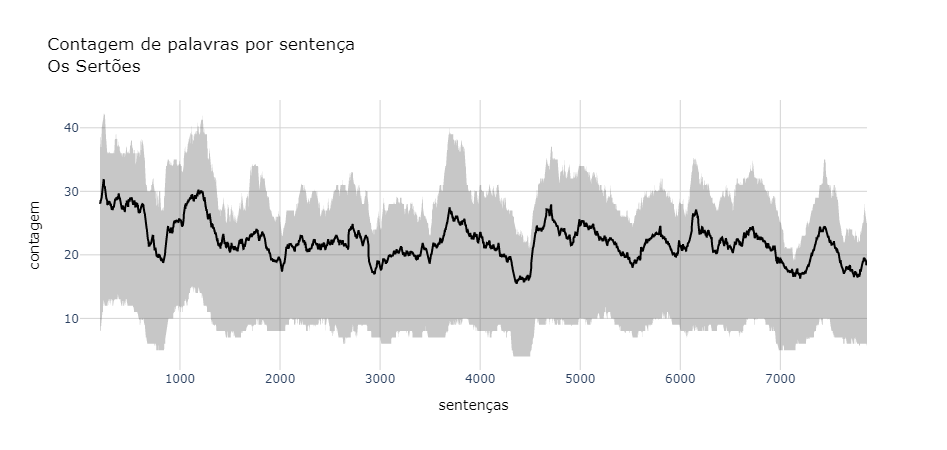

In [166]:
import plotly.graph_objects as go

windowsize=200
stepsize=1

sentences['meancount'] = sentences['tokencount'].rolling(window=windowsize).mean() #contajanela
sentences['devcount'] = sentences['tokencount'].rolling(window=windowsize).std()
sentences['quant25'] = sentences['tokencount'].rolling(window=windowsize).quantile(.25)
sentences['quant75'] = sentences['tokencount'].rolling(window=windowsize).quantile(.75)

linhasrem = sentences.index[np.arange(len(sentences['meancount']))%stepsize==0]
wcount = sentences['meancount'].iloc[linhasrem] #seleciona valores de 20 em 20
linharef = sentences['sentencenumber'].iloc[linhasrem] #seleciona valores de 20 em 20


fig = go.Figure()

fig.add_trace(go.Scatter(
        name='Upper Bound',
        x=sentences['sentencenumber'],
        y=sentences['quant75'], #sentences['meancount']+sentences['devcount'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ))
fig.add_trace(go.Scatter(
        name='Lower Bound',
        x=sentences['sentencenumber'],
        y=sentences['quant25'], #sentences['meancount']-sentences['devcount'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ))

fig.add_trace(go.Scatter(
            x=linharef, 
            y=wcount,
            mode="lines",
            marker_symbol="square",
            hovertemplate="Sentença de Referência: %{x}<br>Contagem palavras:%{y} <extra></extra>",
            hoverlabel_bgcolor="white",
            line_color="black",  showlegend=False
    ))



fig.update_layout(title='Contagem de palavras por sentença<br>{}'.format(booktitle),
                  title_font_color="black",
                  plot_bgcolor= "white",
                  xaxis_title={"text":"sentenças","font_color":"black"},
                  yaxis_title={"text":"contagem","font_color":"black"},
                  xaxis_gridcolor="lightgrey",
                  yaxis_gridcolor="lightgrey")
fig.show()





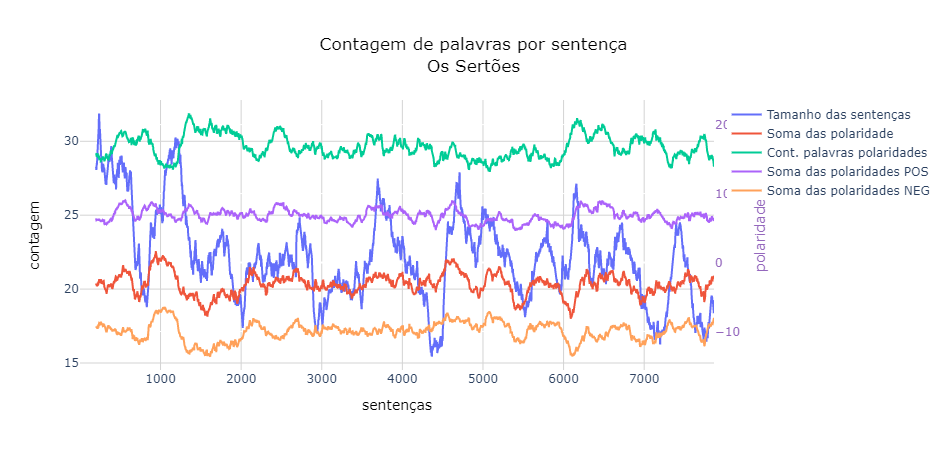

In [181]:
sentencas['polsumjanela'] = sentencas['polsum'].rolling(window=windowsize).sum()
sentencas['polcountjanela'] = sentencas['polcount'].rolling(window=windowsize).sum()
sentencas['polposjanela'] = sentencas['polsumpos'].rolling(window=windowsize).sum()
sentencas['polnegjanela'] = sentencas['polsumneg'].rolling(window=windowsize).sum()
linhasrem = sentencas.index[np.arange(len(sentencas['meancount']))%stepsize==0]

wcount = sentencas['meancount'].iloc[linhasrem] #seleciona valores de 20 em 20
psum = sentencas['polsumjanela'].iloc[linhasrem] 
pcount = sentencas['polcountjanela'].iloc[linhasrem] 
ppos = sentencas['polposjanela'].iloc[linhasrem] 
pneg = sentencas['polnegjanela'].iloc[linhasrem] 
linharef = sentencas['sentencenumber'].iloc[linhasrem] #seleciona valores de 20 em 20

fig = go.Figure({
    "data": [{
            "type": "scatter",
            "name":"Tamanho das sentenças",
            "x": linharef,
            "y": wcount,
            "mode":"lines", #+markers
            "marker_symbol":"square",
            "hovertemplate":"Sentença de Referência: %{x}<br>Contagem palavras:%{y} <extra></extra>",
            "hoverlabel_bgcolor":"white",
            #"line_color":"blue"
             },
             {
            "type": "scatter",
            "name":"Soma das polaridade",
            "x": linharef,
            "y": psum,
            "mode":"lines",
            "marker_symbol":"square",
            "hovertemplate":"Sentença de Referência: %{x}<br>Soma Polaridades:%{y} <extra></extra>",
            "hoverlabel_bgcolor":"white",
            #"line_color":"green",
             "yaxis": 'y2'
             },
             {
            "type": "scatter",
            "name":"Cont. palavras polaridades",
            "x": linharef,
            "y": pcount,
            "mode":"lines",
            "marker_symbol":"square",
            "hovertemplate":"Sentença de Referência: %{x}<br>Contagem polaridades:%{y} <extra></extra>",
            "hoverlabel_bgcolor":"white",
            #"line_color":"red",
             "yaxis": 'y2'
             },
             {
            "type": "scatter",
            "name":"Soma das polaridades POS",
            "x": linharef,
            "y": ppos,
            "mode":"lines",
            "marker_symbol":"square",
            "hovertemplate":"Sentença de Referência: %{x}<br>Soma POS:%{y} <extra></extra>",
            "hoverlabel_bgcolor":"white",
            #"line_color":"green",
             "yaxis": 'y2'
             },
             {
            "type": "scatter",
            "name":"Soma das polaridades NEG",
            "x": linharef,
            "y": pneg,
            "mode":"lines",
            "marker_symbol":"square",
            "hovertemplate":"Sentença de Referência: %{x}<br>Soma NEG:%{y} <extra></extra>",
            "hoverlabel_bgcolor":"white",
            #"line_color":"green",
             "yaxis": 'y2'
             }],
    "layout": {
        "title": {
            "text": 'Contagem de palavras por sentença<br>'+booktitle,
            "xanchor":"center",
            "x":0.5,
            "font_color":"black"
        },
        "plot_bgcolor": "white",
        "xaxis_title":{"text":"sentenças","font_color":"black"},
        "yaxis_title":{"text":"contagem","font_color":"black"},
        "xaxis_gridcolor":"lightgrey",
        "yaxis_gridcolor":"lightgrey",
        "yaxis2": {
            "title": 'polaridade',
            "titlefont": {"color": 'rgb(148, 103, 189)'},
            "tickfont": {"color": 'rgb(148, 103, 189)'},
            "overlaying": 'y',
            "side": 'right'}
    }
})
fig.show()


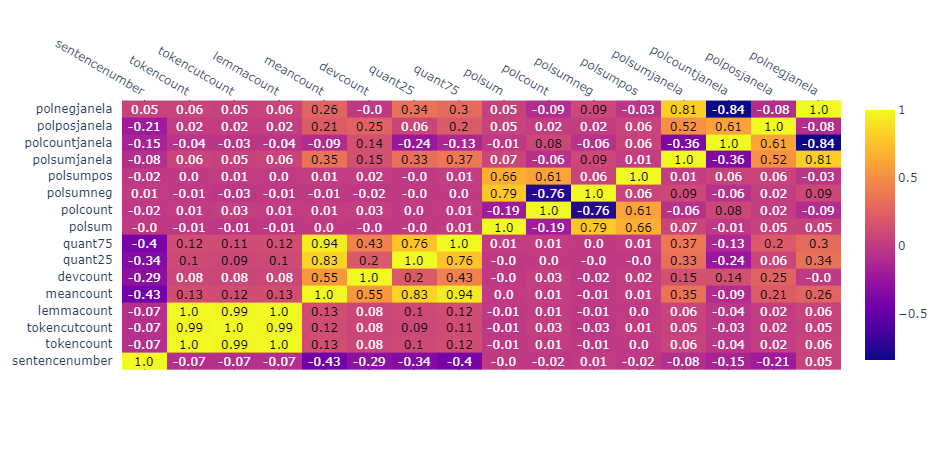

In [183]:
import plotly.figure_factory as ff

corrs = sentencas.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
figure.show()


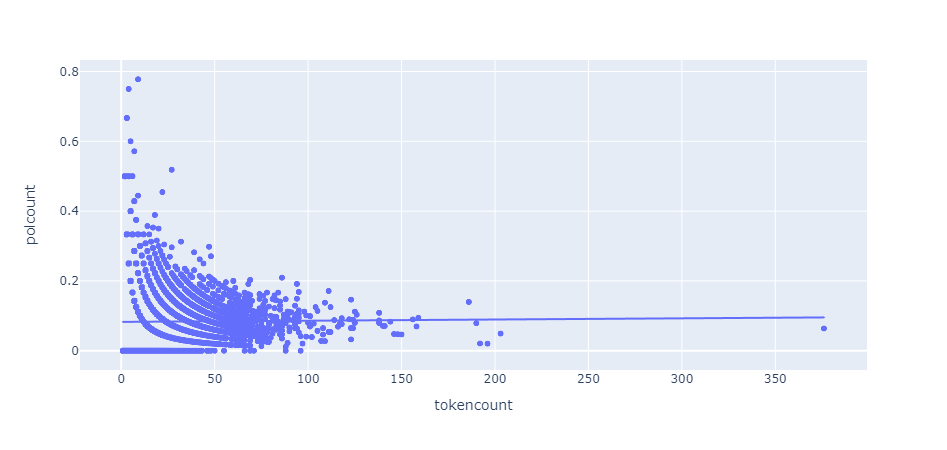

In [186]:
import plotly.express as px

fig = px.scatter(sentencas, x="tokencount", y="polcount", trendline="ols")
fig.show()

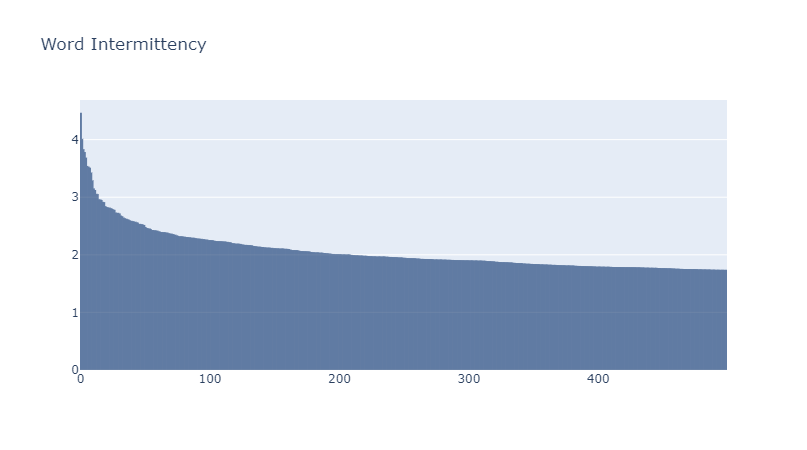

In [274]:
#display(worddist.head(20))

import plotly.graph_objects as go

quant = 500

x = list(range(quant))
y = worddist.head(quant)['intermittency']

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=worddist.head(quant)['token_'])])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Word Intermittency')
fig.show()

#fig.write_html('top{}ngrams_intermittency_{}words.html'.format(quant,size_ngram), include_plotlyjs='cdn')

In [206]:
display(worddf[ (worddf.token == 'Brigada') ] )
display(ng[ (ng.ngram == 'Brigada') ])
display(ngocc[ (ngocc.ngramid == 348166) ])

token     pos     index  distance
19131   Brigada       0       NaN       NaN
127969  Brigada  102101  126821.0  102101.0
127992  Brigada  102124  126848.0      23.0
128017  Brigada  102149  126878.0      25.0
128043  Brigada  102175  126908.0      26.0
128062  Brigada  102194  126931.0      19.0
128086  Brigada  102218  126959.0      24.0
128135  Brigada  102267  127019.0      49.0
131889  Brigada  106021  131630.0    3754.0
131897  Brigada  106029  131642.0       8.0
132010  Brigada  106142  131776.0     113.0
132275  Brigada  106407  132101.0     265.0
132514  Brigada  106646  132392.0     239.0
133629  Brigada  107761  133775.0    1115.0
135299  Brigada  109431  135863.0    1670.0
135598  Brigada  109730  136233.0     299.0
136408  Brigada  110540  137225.0     810.0
136917  Brigada  111049  137840.0     509.0
137424  Brigada  111556  138477.0     507.0
138271  Brigada  112403  139523.0     847.0
140143  Brigada  114275  141816.0    1872.0
140193  Brigada  114325  141878.0      50.0
140562  Brigada  114694  142333.0     369.0
141378  Brigada  115510  143350.0     816.0
141459  Brigada  115591  143447.0      81.0
141522  Brigada  115654  143525.0      63.0
141617  Brigada  115749  143636.0      95.0
141713  Brigada  115845  143752.0      96.0
141786  Brigada  115918  143846.0      73.0
142032  Brigada  116164  144165.0     246.0
142102  Brigada  116234  144251.0      70.0
142699  Brigada  116831  145003.0     597.0
142871  Brigada  117003  145216.0     172.0
143727  Brigada  117859  146279.0     856.0
144242  Brigada  118374  146916.0     515.0
145093  Brigada  119225  147947.0     851.0
148100  Brigada  122232  151673.0    3007.0
149702  Brigada  123834  153681.0    1602.0
150773  Brigada  124905  155017.0    1071.0
151218  Brigada  125350  155559.0     445.0
153599  Brigada  127731  158493.0    2381.0
153679  Brigada  127811  158593.0      80.0
153974  Brigada  128106  158951.0     295.0
155206  Brigada  129338  160493.0    1232.0
155611  Brigada  129743  161004.0     405.0
155794  Brigada  129926  161233.0     183.0
158917  Brigada  133049  165058.0    3123.0
166663  Brigada  140795  174685.0    7746.0
166732  Brigada  140864  174768.0      69.0
168132  Brigada  142264  176490.0    1400.0
170599  Brigada  144731  179533.0    2467.0
172363  Brigada  146495  181753.0    1764.0
177009  Brigada  151141  187488.0    4646.0
182562  Brigada  156694  194384.0    5553.0
191590  Brigada  165722  205811.0    9028.0
192322  Brigada  166454  206753.0     732.0
192596  Brigada  166728  207094.0     274.0
192919  Brigada  167051  207511.0     323.0
219365  Brigada  174364       NaN    7313.0

id    ngram  freq  ngramsize         set
289790  348166  Brigada    57          1  (Brigada,)

line  ngramid
348166  4512   348166
348180  4512   348166
348196  4512   348166
348211  4512   348166
348223  4512   348166
348237  4512   348166
348865  4513   348166
361646  4659   348166
361817  4660   348166
362170  4662   348166
363165  4668   348166
363984  4678   348166
367779  4727   348166
373039  4807   348166
374063  4823   348166
376729  4854   348166
378443  4872   348166
380082  4898   348166
382623  4934   348166
389514  5004   348166
389700  5005   348166
390992  5019   348166
393891  5056   348166
394157  5058   348166
394239  5059   348166
394604  5062   348166
394979  5066   348166
395228  5070   348166
395939  5086   348166
396221  5088   348166
398186  5115   348166
398706  5122   348166
401513  5163   348166
403239  5184   348166
406229  5221   348166
416266  5368   348166
421641  5451   348166
425146  5508   348166
426517  5533   348166
434432  5634   348166
434658  5637   348166
435729  5648   348166
439908  5704   348166
441289  5723   348166
441849  5732   348166
452237  5867   348166
479396  6212   348166
479554  6214   348166
484371  6275   348166
493138  6391   348166
499143  6478   348166
514992  6675   348166
533647  6943   348166
564381  7395   348166
566698  7427   348166
567625  7441   348166
568608  7463   348166

174365

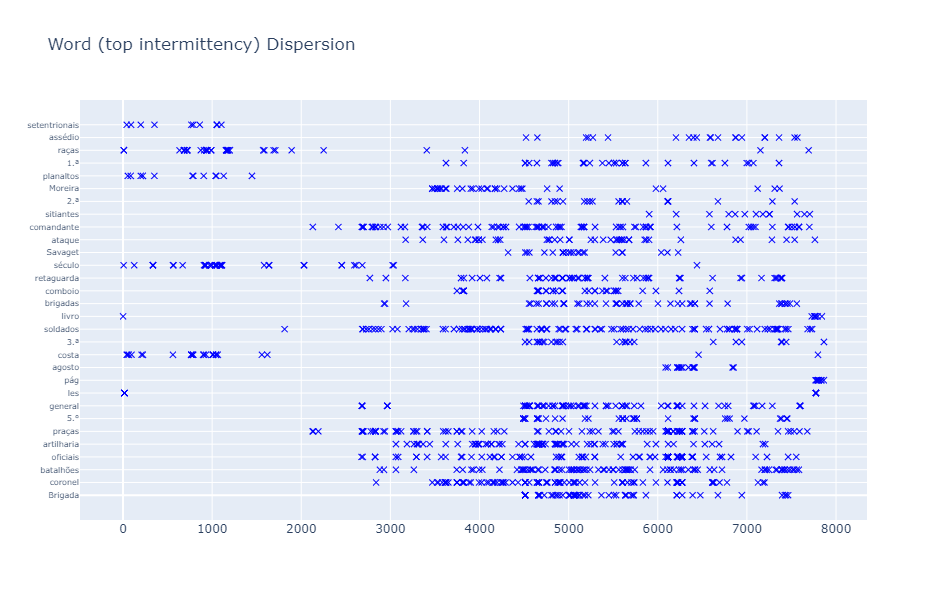

In [208]:
import plotly.graph_objects as go

topn = 30

selected = worddist.token_.head(topn).tolist()

#worddf

ng1 = ng[ng['ngramsize']==1]

#display( ngocc[ (ng1[ ng1.ngram == selected[0] ].id).iloc[0] == ngocc.ngramid ] )

# ngram é diferente de lema
points = [(x, y) 
          for y in range(len(selected))
          for x in ngocc[ (ng1[ ng1.ngram == selected[y] ].id).iloc[0] == ngocc.ngramid ].line.tolist() #por linha do arquivo
          #for x in worddf[ (worddf.word == selected[y]) ].pos.tolist() #por posição da palavra
         ]

#display(ng[ ng.ngram == selected[0] ].id.iloc[0])
#display(ngocc[ (ng[ ng.ngram == selected[0] ].id).iloc[0] == ngocc.ngramid ])

#points = [(x, y) for x in range(len(all_lines))
#          for y in range(len(selected)) if selected[y] in all_lines[x] ]

display(worddf.pos.max())
 
if points:
    x, y = zip(*points)
else:
    x = y = ()
    
fig = go.Figure()
fig.add_trace(go.Scatter( x = x, y = y,
              mode='markers', marker_symbol = 'x-thin', 
              marker_line_color='blue', marker_line_width=1
          )
)
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    #plot_bgcolor='rgba(0,0,0,0)',
    yaxis = dict(
        tickmode = 'array', tickfont_size = 8,
        tickvals = list(range(len(selected))),
        ticktext = selected
    ),
    title_text='Word (top intermittency) Dispersion'
)

fig.show()

#fig.write_html( 'dispersion_top{}ngrams_{}words.html'.format(topn,size_ngram), include_plotlyjs='cdn')
 


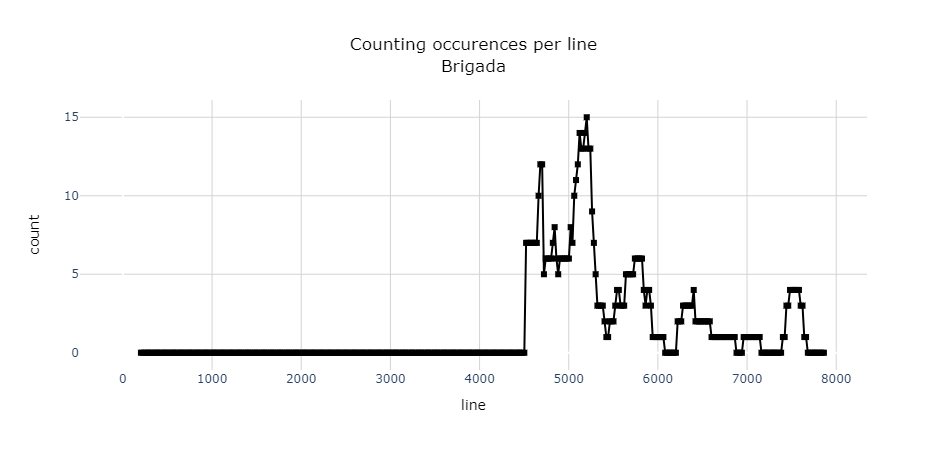

In [214]:
dfline = pd.DataFrame()
dfline['line'] = range(1,ngocc.line.max())

refword = 'Brigada' #mabel, noise, me, her, she, i

dfmyngram = ngocc[ (ng1[ ng1.ngram == refword ].id).iloc[0] == ngocc.ngramid ]

dfmyngram = dfmyngram.groupby("line", as_index=False).count()
dfmyngram = dfmyngram.rename(columns={'ngramid': 'occsum'})

#display(dfmyngram)

dfline = pd.merge(dfline,dfmyngram,left_on='line',right_on='line', how='left', validate='one_to_one')

dfline["occsum"] = dfline["occsum"].fillna(0)

#display(dfline)

by = 20 #step 
win = 200
start = 1 ## it's the index of your 1st valid value.

dfline['sumwin'] = dfline['occsum'].rolling(win).sum()
dfline = dfline[start::by]



fig = go.Figure({
    "data": [{
            "type": "scatter",
            "x": dfline['line'],
            "y": dfline['sumwin'],
            "mode":"lines+markers",
            "marker_symbol":"square",
            "hovertemplate":"Line of reference: %{x}<br>Occurences count:%{y} <extra></extra>",
            "hoverlabel_bgcolor":"white",
            "line_color":"black"
             }],
    "layout": {
        "title": {
            "text": 'Counting occurences per line<br>'+refword,
            "xanchor":"center",
            "x":0.5,
            "font_color":"black"
        },
        "plot_bgcolor": "white",
        "xaxis_title":{"text":"line","font_color":"black"},
        "yaxis_title":{"text":"count","font_color":"black"},
        "xaxis_gridcolor":"lightgrey",
        "yaxis_gridcolor":"lightgrey"
    }
})
fig.show()

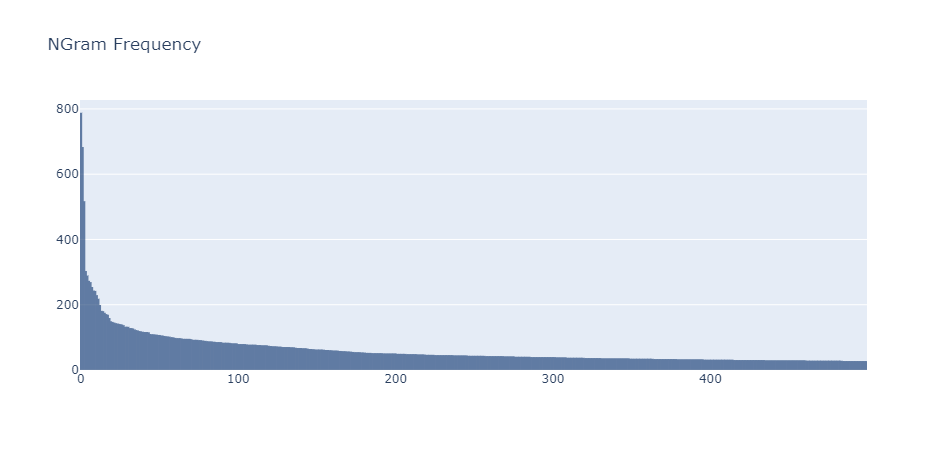

In [236]:
#display(ngocc[ ngocc.ngramid == 25414 ] )

import plotly.graph_objects as go

quant = 500

x = list(range(quant))
y = ng.head(quant)['freq']

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=ng.head(quant)['ngram'])])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='NGram Frequency')
fig.show()

#fig.write_html('top{}ngrams_intermmitency_{}words.html'.format(quant,size_ngram), include_plotlyjs='cdn')

7866

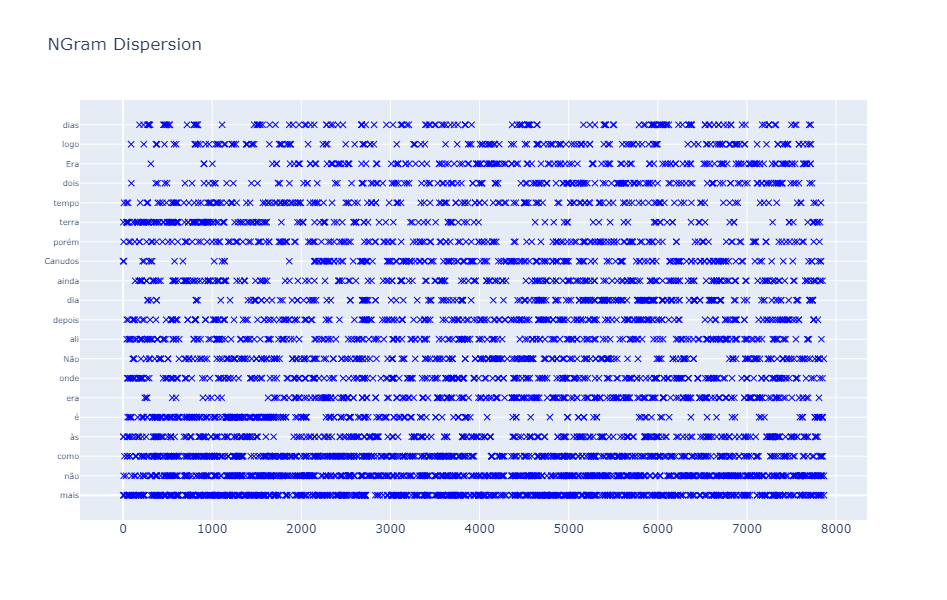

In [240]:
import plotly.graph_objects as go

topn = 20

selected = ng.ngram.head(topn).tolist()

points = [(x, y) 
          for y in range(len(selected))
          for x in ngocc[ (ng[ ng.ngram == selected[y] ].id).iloc[0] == ngocc.ngramid ].line.tolist() 
         ]

#display(ng[ ng.ngram == selected[0] ].id.iloc[0])
#display(ngocc[ (ng[ ng.ngram == selected[0] ].id).iloc[0] == ngocc.ngramid ])

#points = [(x, y) for x in range(len(all_lines))
#          for y in range(len(selected)) if selected[y] in all_lines[x] ]

display(ngocc.line.max())
 
if points:
    x, y = zip(*points)
else:
    x = y = ()
    
fig = go.Figure()
fig.add_trace(go.Scatter( x = x, y = y,
              mode='markers', marker_symbol = 'x-thin', 
              marker_line_color='blue', marker_line_width=1
          )
)
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    #plot_bgcolor='rgba(0,0,0,0)',
    yaxis = dict(
        tickmode = 'array', tickfont_size = 8,
        tickvals = list(range(len(selected))),
        ticktext = selected
    ),
    title_text='NGram Dispersion'
)

fig.show()

#fig.write_html( 'dispersion_top{}ngrams_{}words.html'.format(topn,size_ngram), include_plotlyjs='cdn')
 

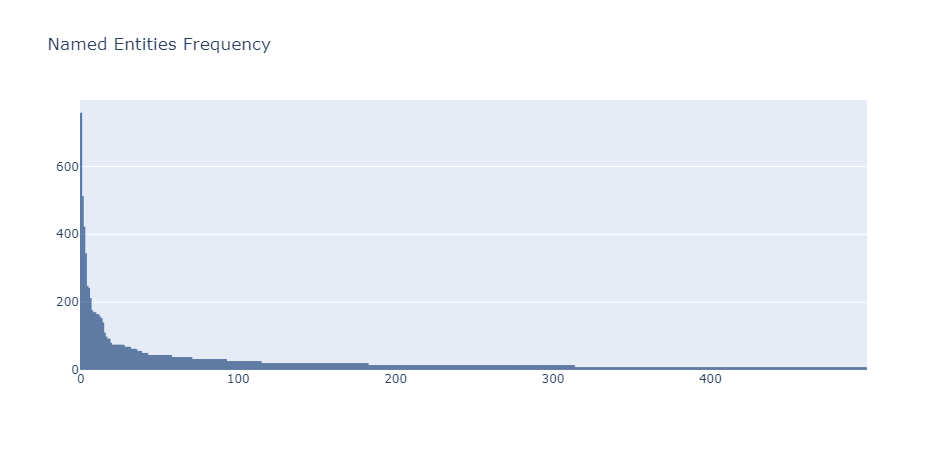

In [257]:
#display(ngocc[ ngocc.ngramid == 25414 ] )

import plotly.graph_objects as go

quant = 500

x = list(range(quant))
y = ng[ng['namedentities']].head(quant)['freq']

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=ng[ng['namedentities']].head(quant)['ngram'])])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Named Entities Frequency')
fig.show()

#fig.write_html('top{}ngrams_intermmitency_{}words.html'.format(quant,size_ngram), include_plotlyjs='cdn')

7866

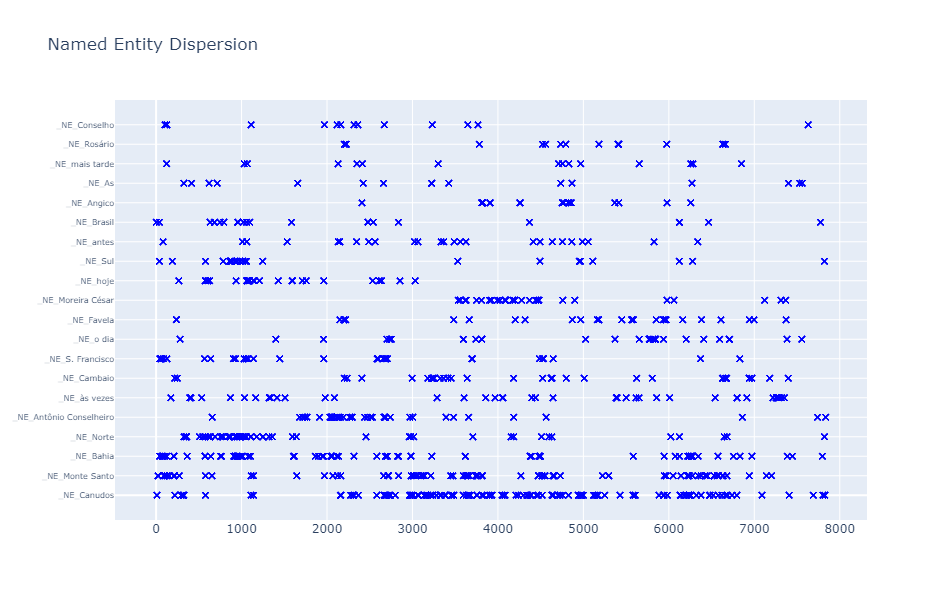

In [258]:
import plotly.graph_objects as go

topn = 20

selected = ng[ng['namedentities']].ngram.head(topn).tolist()

points = [(x, y) 
          for y in range(len(selected))
          for x in ngocc[ (ng[ ng.ngram == selected[y] ].id).iloc[0] == ngocc.ngramid ].line.tolist() 
         ]

#display(ng[ ng.ngram == selected[0] ].id.iloc[0])
#display(ngocc[ (ng[ ng.ngram == selected[0] ].id).iloc[0] == ngocc.ngramid ])

#points = [(x, y) for x in range(len(all_lines))
#          for y in range(len(selected)) if selected[y] in all_lines[x] ]

display(ngocc.line.max())
 
if points:
    x, y = zip(*points)
else:
    x = y = ()
    
fig = go.Figure()
fig.add_trace(go.Scatter( x = x, y = y,
              mode='markers', marker_symbol = 'x-thin', 
              marker_line_color='blue', marker_line_width=1
          )
)
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    #plot_bgcolor='rgba(0,0,0,0)',
    yaxis = dict(
        tickmode = 'array', tickfont_size = 8,
        tickvals = list(range(len(selected))),
        ticktext = selected
    ),
    title_text='Named Entity Dispersion'
)

fig.show()

#fig.write_html( 'dispersion_top{}ngrams_{}words.html'.format(topn,size_ngram), include_plotlyjs='cdn')